### Polyp segmentation using UNet/ Swin Transformers

In [1]:
import os
import cv2
import torch
from torch.utils.data import Dataset

#### Creating the dataset
* Reading the videos and saving all the frames
* Don't need to change the extensions of masks from tiff to png as cv2 can read tiff

In [2]:
ABS_PATH = os.path.abspath('')

In [18]:
dataset_path = os.path.join(ABS_PATH,"TrainingSet_NewGT")

In [67]:
folder_path = os.path.join(dataset_path,"ShortVD_wp_70")
video_path = os.path.join(folder_path,"ShortVD_wp_70.wmv")
video = cv2.VideoCapture(video_path)
save_images_path = os.path.join(folder_path,"Train")
frame_num = 1
success, frame = video.read()
while success:
    cv2.imwrite(os.path.join(save_images_path,"ShortVD_wp_70_frame_"+str(frame_num)+"_GT.png"),frame)
    success, frame = video.read() 
    frame_num += 1

#### Parameters

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
training_path = os.path.join(dataset_path,"Train_1k")
masks_path = os.path.join(dataset_path,"masks_1k") 

In [26]:
num_channels = 3
num_classes = 1
num_levels = 3 

In [25]:
init_lr = 0.0001
num_epochs = 10
batch_size = 5
input_image_width = 256
input_image_height = 256
threshold = 0.5

In [7]:
output_path = os.path.join(ABS_PATH,"evidence/polypSegmentationUNet/")

In [8]:
model_path = os.path.join(output_path, "unet_segmentation_predefined.pt")
plot_path = os.path.join(output_path,"plot.png")

In [52]:
class segmentationDataset(Dataset):
    def __init__(self,imagePaths, maskPaths, transforms) -> None:
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    
    def __len__(self):
        return len(self.imagePaths)
    
    def __getitem__(self, index):
        imagePath = self.imagePaths[index]

        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[index],0)

        if self.transforms is not None:
            image = self.transforms(image)
            mask = self.transforms(mask)
        
        return (image, mask)

In [63]:
import segmentation_models_pytorch as smp

In [11]:
model = smp.Unet(
    encoder_name = "resnet18",
    encoder_weights = "imagenet",
    in_channels = 3,
    classes = 1,
    activation = None
)

model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [5]:
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
from imutils import paths
from tqdm import tqdm
from torchmetrics import JaccardIndex
from torchmetrics import Dice

In [53]:
imagePaths = sorted(list(paths.list_images(training_path)))
maskPaths = sorted(list(paths.list_images(masks_path)))

split = train_test_split(imagePaths, maskPaths, test_size=0.2, random_state=42)

(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]

In [54]:
print(len(trainImages),len(testImages))

2383 596


In [55]:
transforms = transforms.Compose([transforms.ToPILImage(), 
transforms.Resize((input_image_height,input_image_width)),
transforms.ToTensor()])

In [56]:
trainDS = segmentationDataset(imagePaths=trainImages,maskPaths=trainMasks, transforms=transforms)
testDS = segmentationDataset(imagePaths=testImages,maskPaths=testMasks,transforms=transforms)

print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")

[INFO] found 2383 examples in the training set...
[INFO] found 596 examples in the test set...


In [57]:
trainLoader = DataLoader(trainDS, shuffle=True, batch_size=batch_size)
testLoader = DataLoader(testDS, shuffle=True, batch_size=batch_size)

In [58]:
opt = Adam(model.parameters(),lr=init_lr)

In [59]:
trainSteps = len(trainDS)//batch_size
testSteps = len(testDS)//batch_size

In [27]:
metrics = {"dice_loss_train":[],"dice_loss_test":[],"IoU_train":[],"IoU_test":[]}

In [4]:
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.losses import JaccardLoss

In [60]:
dLoss = DiceLoss('binary')
jLoss = JaccardLoss('binary')

In [61]:
import time

In [43]:
print("[INFO] Training the network.")

startTime = time.time()

for e in tqdm(range(num_epochs)):
    model.train()

    totalTrainLoss = 0
    totalTestLoss = 0

    totalTrainLossDice = 0
    totalTestLossDice = 0

    totalTrainLossJac = 0
    totalTestLossJac = 0

    for (i,(x,y)) in enumerate(trainLoader):
        (x,y) = (x.to(device),y.to(device))

        pred = model(x)
        diceLoss = dLoss(pred,y)
        jaccardLoss = jLoss(pred,y)

        opt.zero_grad()
        diceLoss.backward()
        opt.step()

        totalTrainLossDice += diceLoss
        totalTrainLossJac += jaccardLoss
    
    with torch.no_grad():
        model.eval()

        for (x,y) in testLoader:
            (x,y) = (x.to(device), y.to(device))

            pred = model(x)
            # totalTestLoss += fLoss(pred,y)
            totalTestLossDice += dLoss(pred,y)
            totalTestLossJac += jLoss(pred,y)

    
    # avgTrainLoss = totalTrainLoss/trainSteps
    # avgTestLoss = totalTestLoss/testSteps

    avgTrainLossDice = totalTrainLossDice/trainSteps
    avgTestLossDice = totalTestLossDice/testSteps

    avgTrainLossJacc = totalTrainLossJac/trainSteps
    avgTestLossJacc = totalTestLossJac/testSteps

    # update our training history
    # metrics["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    # metrics["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    metrics["dice_loss_train"].append(avgTrainLossDice.cpu().detach().numpy())
    metrics["dice_loss_test"].append(avgTestLossDice.cpu().detach().numpy())
    metrics["IoU_train"].append(avgTrainLossJacc.cpu().detach().numpy())
    metrics["IoU_test"].append(avgTestLossJacc.cpu().detach().numpy())
    
	# print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Dice Train Loss:{:.4f}, Dice Test Loss:{:.4f}, IoU Train:{:.4f}, IoU Test:{:.4f}".format(
		avgTrainLossDice,avgTestLossDice,avgTrainLossJacc,avgTestLossJacc))
        
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))



[INFO] Training the network.


 10%|█         | 1/10 [03:59<35:52, 239.14s/it]

[INFO] EPOCH: 1/10
Dice Train Loss:0.0922, Dice Test Loss:0.0829, IoU Train:0.1659, IoU Test:0.1448


 20%|██        | 2/10 [07:29<29:39, 222.39s/it]

[INFO] EPOCH: 2/10
Dice Train Loss:0.0708, Dice Test Loss:0.0641, IoU Train:0.1298, IoU Test:0.1185


 30%|███       | 3/10 [11:01<25:21, 217.35s/it]

[INFO] EPOCH: 3/10
Dice Train Loss:0.0649, Dice Test Loss:0.0650, IoU Train:0.1200, IoU Test:0.1203


 40%|████      | 4/10 [14:49<22:10, 221.75s/it]

[INFO] EPOCH: 4/10
Dice Train Loss:0.0632, Dice Test Loss:0.0632, IoU Train:0.1159, IoU Test:0.1174


 50%|█████     | 5/10 [18:25<18:17, 219.53s/it]

[INFO] EPOCH: 5/10
Dice Train Loss:0.0581, Dice Test Loss:0.0673, IoU Train:0.1083, IoU Test:0.1214


 60%|██████    | 6/10 [21:28<13:48, 207.06s/it]

[INFO] EPOCH: 6/10
Dice Train Loss:0.0558, Dice Test Loss:0.0553, IoU Train:0.1042, IoU Test:0.1035


 70%|███████   | 7/10 [24:32<09:58, 199.65s/it]

[INFO] EPOCH: 7/10
Dice Train Loss:0.0541, Dice Test Loss:0.0604, IoU Train:0.1011, IoU Test:0.1113


 80%|████████  | 8/10 [27:34<06:27, 193.98s/it]

[INFO] EPOCH: 8/10
Dice Train Loss:0.0529, Dice Test Loss:0.0595, IoU Train:0.0991, IoU Test:0.1101


 90%|█████████ | 9/10 [30:33<03:09, 189.47s/it]

[INFO] EPOCH: 9/10
Dice Train Loss:0.0535, Dice Test Loss:0.0613, IoU Train:0.1001, IoU Test:0.1133


100%|██████████| 10/10 [33:32<00:00, 201.23s/it]

[INFO] EPOCH: 10/10
Dice Train Loss:0.0505, Dice Test Loss:0.0623, IoU Train:0.0950, IoU Test:0.1146
[INFO] total time taken to train the model: 2012.45s


In [44]:
torch.save(model,model_path)

In [65]:
from segmentation_models_pytorch.metrics.functional import iou_score

In [75]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex('binary')

In [78]:
from sklearn.metrics import jaccard_score as jsc

In [81]:
with torch.no_grad():
        model.eval()
        totalIoUScore = 0

        for (x,y) in testLoader:
            (x,y) = (x.to(device), y.to(device))

            pred = model(x)

            lbl = y.cpu().numpy().reshape(-1)
            target = pred.cpu().numpy().reshape(-1)

            totalIoUScore = jsc(target, lbl)

avgIoUScore = totalIoUScore/testSteps

ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
print(avgIoUScore.cpu().detach().numpy())

In [30]:
import matplotlib.pyplot as plt

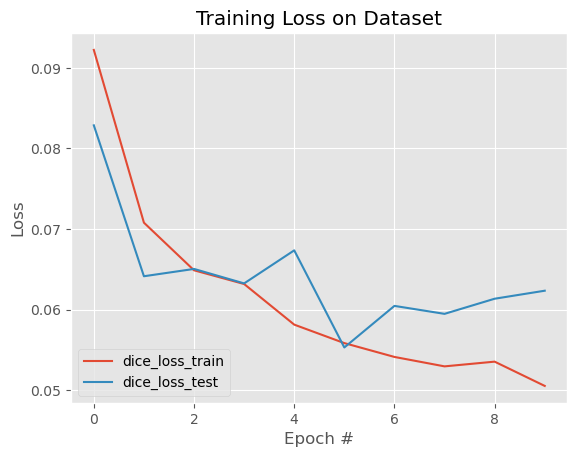

In [46]:
plt.style.use("ggplot")
plt.figure()
plt.plot(metrics["dice_loss_train"], label="dice_loss_train")
plt.plot(metrics["dice_loss_test"], label="dice_loss_test")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)

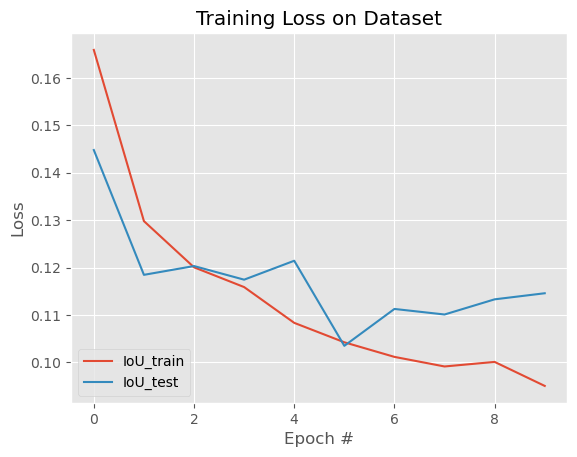

In [47]:
plt.style.use("ggplot")
plt.figure()
plt.plot(metrics["IoU_train"], label="IoU_train")
plt.plot(metrics["IoU_test"], label="IoU_test")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(plot_path)

In [34]:
def prepare_plot(origImage,origMask, predMask):
    figure, ax = plt.subplots(nrows=1,ncols=3, figsize=(10,10))

    ax[0].imshow(origImage)
    ax[1].imshow(origMask)
    ax[2].imshow(predMask)

    ax[0].set_title("Original Image")
    ax[1].set_title("Original mask")
    ax[2].set_title("Predicted mask")

    figure.tight_layout()
    figure.show()

In [14]:
model = torch.load(model_path)

In [28]:
import numpy as np

In [23]:
test_masks_path = os.path.join(dataset_path,"masks")

In [35]:
def make_predictions(model,imagePath):

    model.eval()

    with torch.no_grad():
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = image.astype("float32")/255.0

        image = cv2.resize(image,(256,256))

        orig = image.copy()

        fileName = imagePath.split(os.path.sep)[-1].split("/")[-1]
        fileName = fileName.split('.')[0] + '.tiff'
        groundTruthPath = os.path.join(test_masks_path,fileName)
        print(groundTruthPath)

        gtMask = cv2.imread(groundTruthPath,0)
        gtMask = cv2.resize(gtMask,(input_image_height,input_image_width))

        image = np.transpose(image,[2,0,1])
        image = np.expand_dims(image,0)
        image = torch.from_numpy(image).to(device)

        predMask = model(image).squeeze()
        predMask = torch.sigmoid(predMask)
        predMask = predMask.cpu().numpy()

        predMask = (predMask>threshold)*255

        prepare_plot(orig,gtMask,predMask)
        

In [98]:
test_img = os.path.join(dataset_path,"Train/ShortVD_wp_68_frame_50_GT.png")

d:\Study\Conda Projects\Polyp Detection\TrainingSet_NewGT\masks\ShortVD_wp_68_frame_50_GT.tiff


C:\Users\anish\AppData\Local\Temp\ipykernel_25508\242534179.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


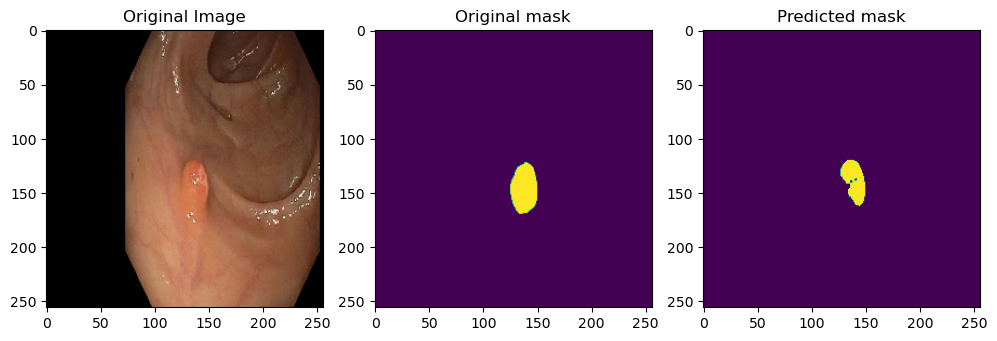

In [99]:
make_predictions(model,test_img)